# 1. Model infrastructure definition (copy and paste from `lstm.ipynb`)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import matthews_corrcoef
import numpy as np
import pandas as pd

In [2]:
def create_one_hot_sets(dataset):
    """
    Processes the dataset by splitting it into predefined sets, 
    standardizing sequence lengths, and applying One-Hot Encoding. 
    """
    # Define the specific dataset partitions (folds) to process
    sets = ["1","2","3","4","5","Benchmark"]
    set_results=[]
    for i in sets:
        # Filter the dataframe to retrieve only rows belonging to the current set ID
        st=dataset.query(f"Set == '{i}'")
        tmp_x=[]
        tmp_y=[]
        # Iterate through each biological sequence in the current set
        for _ , row in st.iterrows():
            
            # --- Sequence Length Standardization (Fixed Length: 90) ---
            # If the sequence is shorter than 90, add padding (using 'X' which becomes zeros)
            seq=row["Sequence"]
            if len(seq) < 90:
                seq=_increase_lenseq(seq)
            # If the sequence is longer than 90, truncate it (keep N-terminus info)
            else:
                seq=seq[:90]

            # --- Feature Extraction ---
            # Convert the standardized string sequence into a One-Hot matrix (90x20)
            encoded_seq = one_hot_encoding(seq)
            tmp_x.append(encoded_seq)

            # --- Label Encoding ---
            # Convert string labels into binary format (1 for Signal Peptide, 0 for others)
            if row["Class"] == "Positive":
                y=1
            else:
                y=0
            tmp_y.append(y)
        tmp_x=np.array(tmp_x, dtype=np.float32)
        tmp_y=np.array(tmp_y, dtype=np.float32)
        set_results.append((tmp_x , tmp_y))
    return set_results
            
def _increase_lenseq(seq):
    """
    Adds padding to the sequence to reach the target length of 90.
    """
    x=len(seq)
    num_of_X= 90-x
    # Append 'X' characters which will be encoded as zero-vectors later
    seq=seq+("X"*num_of_X)
    return seq
            
def one_hot_encoding(sequence):
    """
    Transforms an amino acid sequence into a binary matrix.
    Output shape: (Sequence_Length, 21)
    """
    M = []
    # Standard 20 amino acids alphabet + 1 the X unknown amino acid
    aa_alph = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y','X']
    for aa in sequence:
        one_hot = np.zeros(21)
        try:
            # Find index of the AA (including 'X') and put 1 for that position
            index = aa_alph.index(aa)
            one_hot[index] = 1
        except:
            pass
        M.append(one_hot)
    M = np.array(M)
    return M

In [3]:

class SP_NN(nn.Module):
    def __init__(self, input_size, hidden_sizes,lstm_hidden_size, num_lstm_layers, output_size, dropout_p=0.5):
        """
        Hybrid CNN-LSTM model for Signal Peptide prediction.
        
        Args:
            input_size (int): Dimension of the input vector (21 for Explicit Padding One-Hot).
            hidden_sizes (list): List of integers defining the architecture of the MLP head.
            lstm_hidden_size (int): Number of features in the LSTM hidden state.
            num_lstm_layers (int): Number of stacked LSTM layers.
            output_size (int): Size of the output (1 for binary classification).
            dropout_p (float): Dropout probability for regularization.
        """
        super(SP_NN, self).__init__()

    
        # --- 1. Convolutional Block (Local Feature Extraction) ---
        # We map the 21 input channels to 64 feature maps.
        # Kernel size 17 is chosen to cover typical secondary structure elements.
        self.cnn_out_channels = 64
        self.conv1 = nn.Conv1d(input_size, self.cnn_out_channels, kernel_size=17, padding='same')

        # --- 2. Recurrent Block (Sequential Processing) ---
        # The LSTM takes the 64 features from the CNN as input.
        self.lstm = nn.LSTM(self.cnn_out_channels, lstm_hidden_size, num_lstm_layers, 
                            batch_first=True, dropout=dropout_p if num_lstm_layers > 1 else 0)
        
        # Batch Normalization to stabilize the LSTM output before the classifier
        self.bn = nn.BatchNorm1d(lstm_hidden_size)
        
        # --- 3. Dynamic MLP Head (Classification) ---
        mlp_layers = []
        current_input_size = lstm_hidden_size 
        
        # Dynamically build hidden layers based on the configuration chosen
        for hidden_size in hidden_sizes:
            # Linear Layer
            mlp_layers.append(nn.Linear(current_input_size, hidden_size))
            # Activation Function (ReLU introduces non-linearity)
            mlp_layers.append(nn.ReLU())
            # Regularization (Dropout prevents overfitting)
            mlp_layers.append(nn.Dropout(p=dropout_p))
            # Update input dimension for the next layer
            current_input_size = hidden_size
            
        # Final Output Layer
        mlp_layers.append(nn.Linear(current_input_size, output_size))
        
        # Sigmoid activation for binary output (0-1)
        mlp_layers.append(nn.Sigmoid()) 
        
        # Assemble all the individual layers into a single functional block.
        # This connects them in order, so data flows through them automatically.
        # (Without this, you would have to call each layer manually in the forward pass, 
        # which is impossible when the number of layers is dynamic).
        self.mlp = nn.Sequential(*mlp_layers)

    def forward(self, x):
        # Input x shape: [Batch, Length(90), Channels(21)]
        
        # --- 1. Convolutional Block ---
        # Conv1d needs input as [Batch, Features, Length]
        x = x.permute(0, 2, 1) 
        x = self.conv1(x)     
        # Output shape: [Batch, 64, 90]
        
        # --- 2. Recurrent Block (LSTM) ---
        # LSTM needs input as [Batch, Length, Features] -> Permute back
        x = x.permute(0, 2, 1)
        out, _ = self.lstm(x)

        # LSTM Output shape: [Batch, 90, Hidden_Size]
        
        # --- 3. Sequence Summarization ---
        # Select only the output of the last time step.
        # This summarizes the entire 90-AA sequence into a single vector.
        # Shape transformation: [Batch, 90, Hidden] -> [Batch, Hidden]
        out = out[:, -1, :] 
        out = self.bn(out)
        
        # --- 4. Classification Head ---
        # Normalize and pass through the dynamic MLP
        out = self.mlp(out)
        return out


class SignalDataset(Dataset):
    """
    Custom Dataset class designed for memory efficiency ('Lazy Loading').
    It converts data to Tensors only when needed, preventing RAM saturation.
    """
    def __init__(self, X, y):
        # Store references to the raw data (NumPy arrays).
        # CRITICAL: We do NOT convert to Tensors here to avoid duplicating memory usage
        # immediately. The data remains in its original, lighter format until requested.
        self.X = X 
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Convert only the requested sample (at index 'idx') to a PyTorch Tensor.
        # This keeps the memory footprint low during training.
        x_out = torch.from_numpy(self.X[idx]).float() 
        
        # Transform the scalar label (e.g., 0) into a vector (e.g., [0]).
        # Using .view(1) is necessary to match the model's output shape [Batch_Size, 1]
        # and avoid dimension mismatch errors with the Loss Function (BCELoss)
        y_out = torch.tensor(self.y[idx], dtype=torch.float32).view(1)
        
        return x_out, y_out


def train_val(model, 
              train_loader, 
              val_loader,
              optimizer, 
              criterion, 
              epochs, 
              patience,
              scorer = matthews_corrcoef,
              init_best_score = -1,
              output_transform = lambda x: (x > 0.5).float()):
  """
    Executes the training and validation loop with Early Stopping and Gradient Clipping.

    Args:
        model (nn.Module): The PyTorch neural network to train (e.g., SignalNet).
        train_loader (DataLoader): DataLoader containing the training batches.
        val_loader (DataLoader): DataLoader containing the validation batches.
        optimizer (torch.optim.Optimizer): Algorithm to update model weights (e.g., Adam).
        criterion (nn.Module): Loss function to measure error (e.g., BCELoss).
        epochs (int): Maximum number of training epochs.
        patience (int): Number of epochs to wait for improvement before stopping early.
        scorer (callable, optional): Metric function to evaluate model performance (default: MCC).
        init_best_score (float, optional): Initial baseline score for model tracking.
        output_transform (callable, optional): Function to convert raw outputs to class labels.
    Returns:
        dict: The state_dict (weights) of the best performing model found during training.
  """
  # Initialize tracking variables for Early Stopping
  best_val_score = init_best_score 
  epochs_without_improvement = 0
  best_model_state_dict = None 

  for epoch in range(epochs): #ripeti il processo per epoche volte. 
    # ===========================
    #      TRAINING PHASE
    # ===========================
    # Set model to training mode (enables Dropout and BatchNorm updates)
      model.train()
      # Initialize accumulator for the epoch loss
      loss = 0
      for batch_X, batch_y in train_loader: 
         # Move data to GPU (if available), useful to speed up performances
          batch_X, batch_y = batch_X.to(device), batch_y.to(device)      
          # 1. Reset Gradients (Clear previous step's gradients)
          optimizer.zero_grad()    
          # 2. Forward Pass (Compute predictions)    
          outputs = model(batch_X)      
          # 3. Compute Loss (Compare predictions vs targets)
          loss = criterion(outputs, batch_y)        
          # 4. Backward Pass (Compute gradients) 
          loss.backward()         
          # 5. Gradient Clipping (CRITICAL for LSTMs)
          # Prevents "exploding gradients" by capping the norm to 1.0
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          # 6. Optimizer Step (Update weights)
          optimizer.step() #prende i calcoli della backward e aggiorna fisicamente i pesi del cervello per ridurre l'errore

    # ===========================
    #     VALIDATION PHASE
    # ===========================
    # Set model to evaluation mode (disables Dropout)
      model.eval() 
      val_preds = []
      val_labels = []
      with torch.no_grad(): # Disable gradient calculation for validation (saves memory and computation)
          for batch_X, batch_y in val_loader: 
              batch_X, batch_y = batch_X.to(device), batch_y.to(device)
              outputs = model(batch_X)
              # Transform output probabilities to class labels (0 or 1)
              preds = output_transform(outputs) #utilizza il metodo di traformazione conenuto in output _transform permettendolo di variare a piacimento
              # Store predictions and labels for metric calculation
              val_preds.extend(preds.cpu().numpy().flatten()) #aggiunge le risposte alle liste
              val_labels.extend(batch_y.cpu().numpy().flatten())
      
      # Calculate validation metric (MCC)
      val_score = scorer(val_labels, val_preds) 
        # ===========================
        #      EARLY STOPPING
        # ===========================
        # Check if current model is better than the best found so far
      if val_score > best_val_score:
          best_val_score = val_score
          epochs_without_improvement = 0
          # Save the best model weights in memory
          best_model_state_dict = model.state_dict()
          # print('Validation score improved to {:.4f}'.format(best_val_score))
      else:
          # No improvement: increase patience counter
          epochs_without_improvement += 1
          if epochs_without_improvement >= patience:
              # print('Early stopping at epoch {}'.format(epoch+1))
              break # Stop training

      # print('Epoch [{}/{}], Loss: {:.4f}, Val score: {:.4f}'.format(epoch+1, epochs, loss.item(), val_score))
  return best_model_state_dict # Return the best weights found during training

def test(model, test_loader, scorer = matthews_corrcoef, output_transform = lambda x: (x > 0.5).float()):
  """
    Evaluates the trained model on a test dataset without updating weights.

    Args:
        model (nn.Module): The trained PyTorch model to evaluate.
        test_loader (DataLoader): DataLoader containing the test dataset batches.
        scorer (callable, optional): Metric function to calculate the final score (default: matthews_corrcoef).
        output_transform (callable, optional): Function to convert raw model outputs (probabilities) 
            into binary class labels (default: threshold > 0.5).

    Returns:
        float: The calculated performance score (e.g., MCC) on the entire test set.
  """
  model.eval() # Set model to evaluation mode (disables Dropout and BatchNorm statistics updates)
  all_preds = []
  all_labels = []
  with torch.no_grad():
      for batch_X, batch_y in test_loader:
          batch_X, batch_y = batch_X.to(device), batch_y.to(device) # Move data to the configured device (GPU or CPU)
          outputs = model(batch_X) # Forward pass: compute predictions
          preds = output_transform(outputs) # Apply threshold to get binary class labels (e.g., > 0.5 -> 1)

          # Move tensors to CPU, convert to NumPy arrays, and flatten them
          # (Required for Scikit-learn metrics like MCC which work on CPU arrays)
          all_preds.extend(preds.cpu().numpy().flatten()) 
          all_labels.extend(batch_y.cpu().numpy().flatten())
 # Calculate the final performance score based on all predictions
  score = scorer(all_labels, all_preds) #MCC
  return score , all_preds

# --- Device Configuration ---
# Check if a NVIDIA GPU with CUDA support is available on the system.
if torch.cuda.is_available():
    # Set the computation device to GPU.
    # All models and tensors moved to this device will use VRAM and hardware acceleration.
    device = torch.device("cuda")
    print("GPU is available")
else:
    # Fallback to CPU if no compatible GPU is found.
    # Training will work but will be significantly slower.
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available


# 2. Optimal Hyperparameter Configuration

In this section, we manually define the **best set of hyperparameters** identified during the optimization phase (see `lstm.ipynb`).

Among the 15 trials performed using Random Search with ASHA, this specific configuration achieved the highest **Validation MCC** (Mean across 5 folds).

### Selected Architecture Analysis
The tuning process selected a **"Flexible" (Hourglass)** topology for the MLP Head:
* **Hidden Layers:** `[256, 128, 64, 1024]`
* **Observation:** The network compresses features down to 64 dimensions before expanding them to a massive 1024-neuron layer just before classification. This suggests that projecting compressed features into a higher-dimensional space helps the final linear classifier separate the classes more effectively.

### Training Parameters
* **LSTM:** 2 stacked layers with 128 hidden units each.
* **Optimization:** A very conservative Learning Rate (`~2.8e-4`) combined with high Dropout (`~0.5`), indicating that strong regularization was necessary to prevent overfitting given the model's complexity.

In [4]:
# Configuration retrieved from the Best Trial (Ray Tune)
# Metric: Maximize MCC on 5-Fold Cross-Validation
config= {'num_layers': 4, 'hidden_sizes': [256, 128, 64, 1024], 'dropout': 0.4980673167779849, 'lr': 0.00028585527498522286, 'batch_size': 20, 'num_lstm_layers': 2, 'lstm_hidden_size': 128}

In [5]:
#Load the dataset
dataset = pd.read_csv("../Data_Preparation/train_bench.tsv", sep="\t")

# Apply the one hot encoding
all_data = create_one_hot_sets(dataset)

In [70]:
# --- 1. DATA SPLITTING CONFIGURATION ---
# Define specific indices for the final split:
# Sets 0, 1, 2, 3 -> Used for Training (Maximized data availability)
# Set 4 -> Used for Validation (Early Stopping monitoring)
# Set 5 -> Used for Final Testing (Benchmark)
training_indices=[0,1,2,3]
validation_index=4
testing_index=5

# --- 2. TRAINING SET ASSEMBLY ---
# Collect feature matrices (X) and target vectors (y) for the 4 training folds
train_x_list = [all_data[j][0] for j in training_indices]
train_y_list = [all_data[j][1] for j in training_indices]

# Concatenate the list of arrays into single contiguous arrays for training
x_train_conc = np.concatenate(train_x_list, axis=0)
y_train_conc = np.concatenate(train_y_list, axis=0)

# --- 3. VALIDATION & TEST SET PREPARATION ---
# Extract Validation and Test sets directly (single folds, no concatenation needed)
x_val = all_data[validation_index][0]
y_val = all_data[validation_index][1]

x_test = all_data[testing_index][0]
y_test = all_data[testing_index][1]

# --- 4. DATASET INITIALIZATION ---
# Initialize the custom SignalDataset. 
# Note: We pass raw NumPy arrays; conversion to Tensor happens lazily in __getitem__ to save RAM.
train_dataset = SignalDataset(x_train_conc, y_train_conc)
val_dataset = SignalDataset(x_val, y_val)
test_dataset = SignalDataset(x_test, y_test)

# --- 5. DATALOADER SETUP ---
# Create DataLoaders to handle batching. 
# Shuffle=True for training is crucial to break data order bias and ensure stable gradients.
train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config["batch_size"])
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"])

# --- 6. MODEL INITIALIZATION ---
# Instantiate the hybrid CNN-LSTM model using the best hyperparameters from the 'config' dictionary.
model = SP_NN(
input_size=21, 
hidden_sizes=config["hidden_sizes"],
lstm_hidden_size=config["lstm_hidden_size"],
num_lstm_layers=config["num_lstm_layers"],
output_size=1,
dropout_p=config["dropout"]
).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["lr"])
criterion = nn.BCELoss()

# --- 7. TRAINING LOOP ---
# Execute training with Early Stopping. 
# best_state will contain the weights of the best performing epoch (not necessarily the last one).
best_state = train_val(model, train_loader, val_loader, optimizer, criterion,
                   epochs=100, patience=20)

# --- 8. MODEL LOADING & INFERENCE ---
# Load the optimal weights back into the model architectur
model.load_state_dict(best_state)

# Run inference on the Benchmark Set (Test)
# Returns the MCC score and the raw predictions for analysis
mcc, all_preds = test(model, test_loader)
print("MCC on benchmark set:", mcc)


MCC on benchmark set: 0.9018711109052984


# 3. Model Export for Deployment

In this final step, we export the trained model to a file for future use.

Instead of simply saving the weights (State Dict) or using Python's `pickle` (which requires the original `class SP_NN` code to be present during loading), we utilize **TorchScript** via **JIT Tracing**.

### Methodology: JIT Tracing
We create a "dummy input" (a random tensor with the same shape as a protein sequence) and pass it through the model. PyTorch traces the execution path and records all the operations performed.

**Advantages of this approach:**
1.  **Standalone:** The resulting `.pt` file contains both the **architecture** and the **weights**. You can load this model anywhere *without* needing the original Python source code.
2.  **Portability:** The exported model can be loaded in non-Python environments (e.g., C++ for high-performance inference) or integrated into production pipelines easily.
3.  **Determinism:** By setting the model to evaluation mode before tracing, we ensure that stochastic layers like Dropout are disabled in the saved version.

In [7]:
# --- Model Export (TorchScript) ---

# 1. Prepare Model for Tracing
# Switch to evaluation mode. This is CRITICAL because it disables Dropout 
# and freezes Batch Normalization statistics, ensuring deterministic behavior.
model.eval()

# 2. Create Dummy Input
# Generate a random tensor with the exact shape of the expected input:
# [Batch_Size=1, Sequence_Length=90, Channels=21 (One-Hot)]
# The tracer needs this to "flow" through the network and record operations.
dummy_input = torch.randn(1, 90, 21).to(device)

# 3. Trace the Model
# Converts the PyTorch model into a TorchScript module.
# Result: A standalone file containing both the architecture logic and the learned weights.
traced_model = torch.jit.trace(model, dummy_input)

# 4. Save to Disk
# This file can now be loaded in C++, Java, or another Python script 
# WITHOUT needing the original 'class SignalPeptideLSTM' definition.
torch.jit.save(traced_model, "SignalPeptideLSTM.pt")

# --- How to Load (Example) ---
# model = torch.jit.load("SignalNet_complete.pt")

# 4. Analysis of Results

In this section, we analyze the performance of the trained model on the Benchmark Set.

We specifically focus on identifying misclassified sequences to categorize them into:
* **False Negatives:** Signal Peptides missed by the model.
* **False Positives:** Non-Signal Peptides incorrectly classified as Signal Peptides.

In [18]:
from sklearn.metrics import matthews_corrcoef , confusion_matrix , accuracy_score , precision_score , recall_score

In [8]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis, ProtParamData
import statistics as st
# function to get the features

def get_scale_features (seq, scale ,window, output_type): 
        
    ''' This function returns the features (max score and average score) of a chosen scale for a specific sequence. You can use a personalized 
    dictionary of scores or a one inside ProtParamData. You can check all the ProtParamData scales using the command dir(ProtParamData) A legend of each 
    param argument is given at the beginning of this file'''

    sequence = ProteinAnalysis(seq) 
    if type(scale)==dict:   
        scale_result = sequence.protein_scale(scale, window, edge=1)
        if len(seq)<window:
            scale_result = sequence.protein_scale(scale, len(seq), edge=1)
    else:

        param_dict = getattr(ProtParamData, scale)
        scale_result = sequence.protein_scale(param_dict, window, edge=1)
        if len(seq)<window:
            scale_result = sequence.protein_scale(param_dict, len(seq), edge=1)
    max_value=max(scale_result)
    mean_value=st.mean(scale_result)
    if output_type == "mean" :
        return mean_value
    else:
        return max_value

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
# --- 1. Load the Production Model ---
# We load the JIT-compiled model directly from the disk.
# This ensures we test exactly what we would deploy.
model = torch.jit.load("SignalPeptideLSTM.pt")

In [69]:
# --- 2. Prepare Benchmark Data ---
testing_index=5
x_test = all_data[testing_index][0]
y_test = all_data[testing_index][1]

# Create Dataset and Loader for the Benchmark
test_dataset = SignalDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=20)

# --- 3. Run Inference ---
# Retrieve metrics and raw predictions
mcc, bench_pred = test(model, test_loader)
print("MCC on benchmark set:", mcc)
benchmark_set=dataset.query("Set=='Benchmark'")
print("length of prediction vectors:", len(all_preds))
print("length of the benchmark set:", len(benchmark_set))

# --- 4. Error Identification Loop ---
# We compare predictions vs ground truth element by element.
# (Note: 'svm_' prefix is legacy naming, here referring to Neural Net errors)
svm_fp = []
svm_fn = []
for i in range(len(y_test)):
    if bench_pred[i] == 0 and y_test[i] == 1:
        svm_fn.append(i) #we are appending i, that is a row index
    elif bench_pred[i] == 1 and y_test[i] == 0:
        svm_fp.append(i)
    else:
        pass

MCC on benchmark set: 0.9018711109052984
length of prediction vectors: 2006
length of the benchmark set: 2006


In [71]:
# now import the dataset and create dataframes that only contain data of interest
benchmark=dataset.query("Set=='Benchmark'")
false_positives_df = benchmark.iloc[svm_fp] #dataframe with only fp entries
false_negatives_df = benchmark.iloc[svm_fn] #dataframe with only fn entries
true_positives_df = benchmark.query("Class == 'Positive'") #dataframe with only tp entries
true_negatives_df = benchmark.query("Class == 'Negative'") #dataframe with only tn entries

# create a new column in the benchmark dataframe to store information about classification
rows = benchmark.shape[0]
classification_col = []
for i in range(rows):
    # if the row number is in svm_fp or svm_fn, append FP or FN to the classification column
    if i in svm_fp:
        classification_col.append("FP")
        continue
    elif i in svm_fn:
        classification_col.append("FN")
        continue
    #if the row number is not in svm_fp or svm_fn lists, it means the corresponding entry is correctly classified
    elif benchmark.iloc[i]["Class"] == "Negative":
        classification_col.append("TN")
    elif benchmark.iloc[i]["Class"] == "Positive":
        classification_col.append("TP")

#create new dataframe "prediction_dataset"
prediction_dataset=benchmark.copy()
prediction_dataset["Prediction"]=classification_col


Neural Network Metrics:
MCC = 0.9018711109052984 
Precision = 0.9209302325581395 
Sensitivity = 0.9041095890410958 
Accuracy = 0.9810568295114656


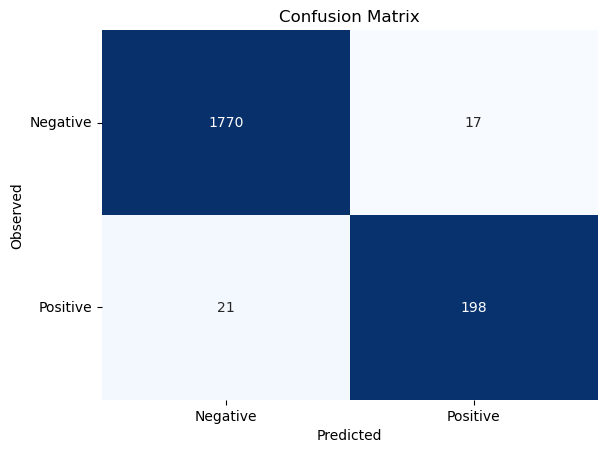

In [72]:
conf_mat = confusion_matrix( y_test, bench_pred)
svm_mcc = matthews_corrcoef(y_test , bench_pred)
svm_precision = precision_score(y_test , bench_pred)
svm_sensitivity = recall_score(y_test , bench_pred)
svm_accuracy = accuracy_score(y_test , bench_pred)
print(f"Neural Network Metrics:\nMCC = {svm_mcc} \nPrecision = {svm_precision} \nSensitivity = {svm_sensitivity} \nAccuracy = {svm_accuracy}")
sns.heatmap(
        conf_mat,
        annot=True,
        cmap="Blues",
        fmt="d",
        cbar=False,
        vmax = 200      
    )
plt.xlabel("Predicted")
plt.ylabel("Observed")  
plt.title("Confusion Matrix")  
plt.xticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"])
plt.yticks(ticks=[0.5, 1.5], labels=["Negative", "Positive"], rotation=0)
plt.show()

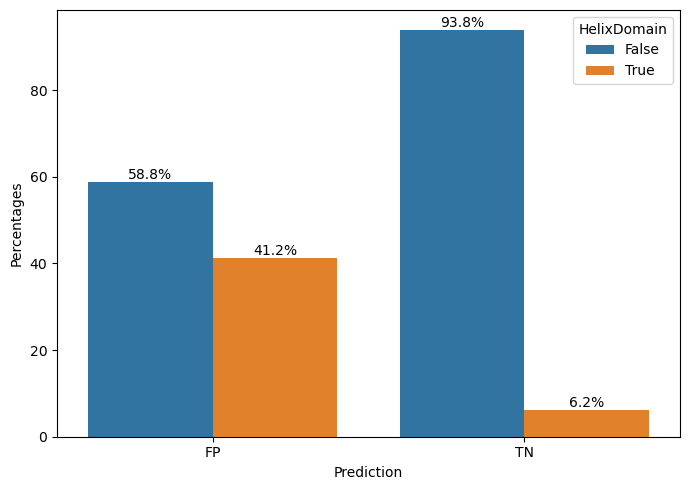

In [ ]:
# make counts in function of prediction and helix domain presence
counts = (
    prediction_dataset
    .groupby(["Prediction", "HelixDomain"])
    .size()
    .rename("n")
    .reset_index()
)

# compute percentage within each prediction group relative to its own size
counts["percent"] = counts.groupby("Prediction")["n"].transform(lambda s: ( s / s.sum())*100)

# plot the histogram
plt.figure(figsize=(7,5))
ax = sns.barplot(data=counts, x="Prediction", y="percent", hue="HelixDomain")
ax.set_ylabel("Percentages")
ax.set_xlabel("Prediction")
ax.legend(title="HelixDomain")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%")
    
plt.tight_layout()
plt.savefig("model_evaluation/HD_prediciton_1.png", dpi=300)
plt.show()


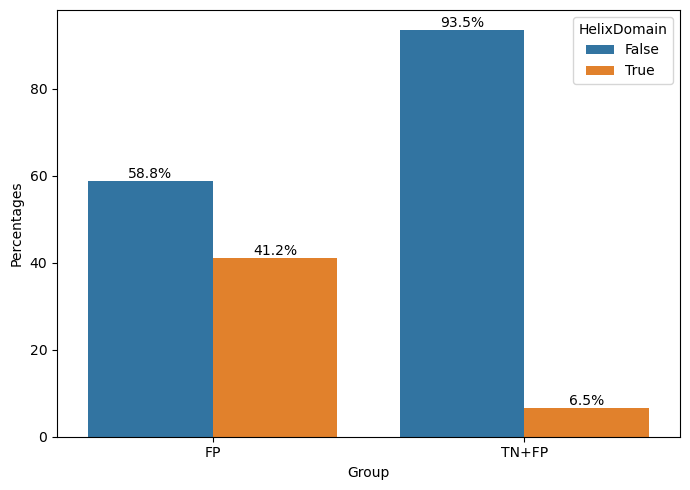

In [ ]:
# create the subset with all negatives (fp+tn) and a version with only the fp

all_negatives=prediction_dataset.query("Class=='Negative'").copy()
all_negatives['Group']="TN+FP" #change this to change the label on the x-axis
false_positive=prediction_dataset.query("Prediction=='FP'").copy()
false_positive['Group']="FP" #change this to change the label on the x-axis
counts_group=pd.concat([false_positive,all_negatives], ignore_index=True)

# make counts in function of group and helix domain presence
counts = (
    counts_group
    .groupby(["Group", "HelixDomain"])
    .size()
    .rename("n")
    .reset_index()
)
# compute percentage within fp group and total negatives relative to its own size
counts["percent"] = counts.groupby("Group")["n"].transform(lambda s: ( s / s.sum())*100)

# make the plot
plt.figure(figsize=(7,5))
ax = sns.barplot(data=counts, x="Group", y="percent", hue="HelixDomain")
ax.set_ylabel("Percentages")
ax.set_xlabel("Group")
ax.legend(title="HelixDomain")
for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%")
plt.tight_layout()
plt.savefig("model_evaluation/HD_prediction_2.png", dpi=300)
plt.show()

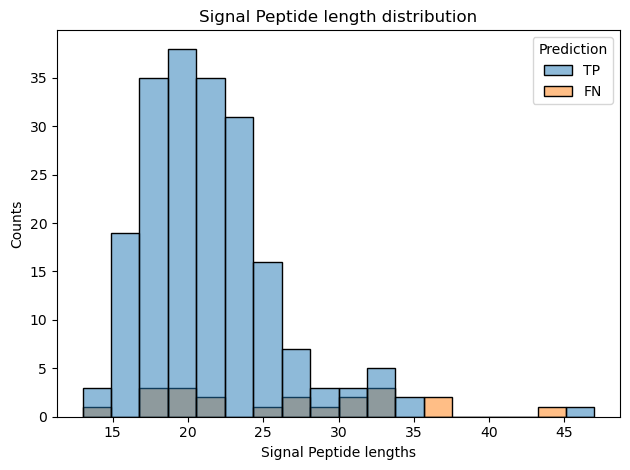

In [ ]:
#signal peptide length distribution histogram
length_df = prediction_dataset.query("Class == 'Positive'").copy()
length_df["sp_length"] = prediction_dataset["SPEnd"] - prediction_dataset["SPStart"]

sns.histplot(
    data=length_df,
    x="sp_length",
    hue="Prediction",
)

plt.title("Signal Peptide length distribution")
plt.ylabel("Counts")
plt.xlabel("Signal Peptide lengths")

plt.tight_layout()
plt.savefig("model_evaluation/Signalength_distribution.png", dpi=300)
plt.show()

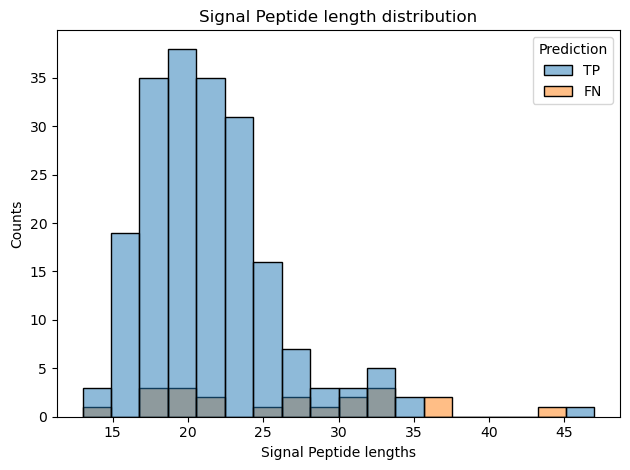

In [ ]:

#signal peptide length distribution histogram
length_df = prediction_dataset.query("Class == 'Positive'").copy()
length_df["sp_length"] = prediction_dataset["SPEnd"] - prediction_dataset["SPStart"]

sns.histplot(
    data=length_df,
    x="sp_length",
    hue="Prediction",
)

plt.title("Signal Peptide length distribution")
plt.ylabel("Counts")
plt.xlabel("Signal Peptide lengths")

plt.tight_layout()
plt.savefig("model_evaluation/Signalength_distribuion2.png", dpi=300)
plt.show()

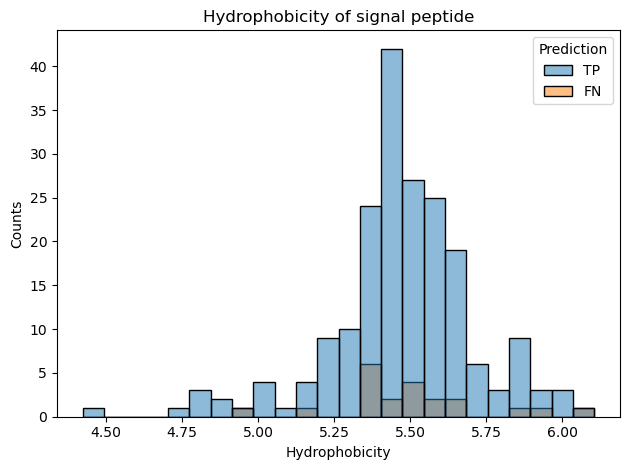

In [ ]:
#hydrophobicity distribution

hydro_df = prediction_dataset.query("Class == 'Positive'").copy()

hydro_df["hydrophobicity"] = hydro_df.apply(
    lambda row: get_scale_features(row["Sequence"], "mi", int(row["SPEnd"] - row["SPStart"]) , "mean"),
    axis=1
)

sns.histplot(
    data=hydro_df,
    x="hydrophobicity",
    hue="Prediction",
    
)

plt.title("Hydrophobicity of signal peptide")
plt.ylabel("Counts")
plt.xlabel("Hydrophobicity")

plt.tight_layout()
plt.savefig("model_evaluation/Hydrophobicity_SP.png", dpi=300)
plt.show()



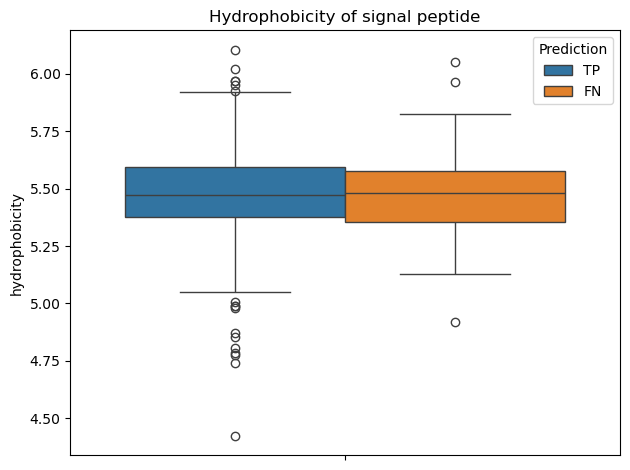

In [ ]:
sns.boxplot(
    data=hydro_df,
    y="hydrophobicity",
    hue="Prediction",
    
)

plt.title("Hydrophobicity of signal peptide")
plt.tight_layout()
plt.savefig("model_evaluation/Boxplot_Hydrophobicity_SP.png", dpi=300)
plt.show()

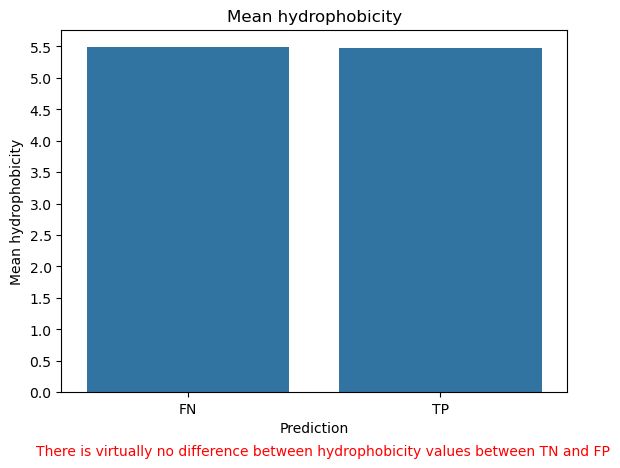


 Prediction
FN    5.492710
TP    5.470546
Name: hydrophobicity, dtype: float64 



In [ ]:
# mean hydrophobicity percentage
import seaborn as sns
import matplotlib.pyplot as plt

hydro_means = hydro_df.groupby('Prediction')['hydrophobicity'].mean()

sns.barplot(x=hydro_means.index, y=hydro_means.values)

y_ticks = [i/10 for i in range(0, 60, 5)]
plt.ylabel("Mean hydrophobicity")  
plt.yticks(y_ticks)
plt.title("Mean hydrophobicity")
plt.text(-0.6, -1, "There is virtually no difference between hydrophobicity values between TN and FP", color='red', fontsize=10)
plt.tight_layout()
plt.savefig("model_evaluation/Mean_hydrophobicity.png", dpi=300)
plt.show()
print("\n", hydro_means ,"\n")

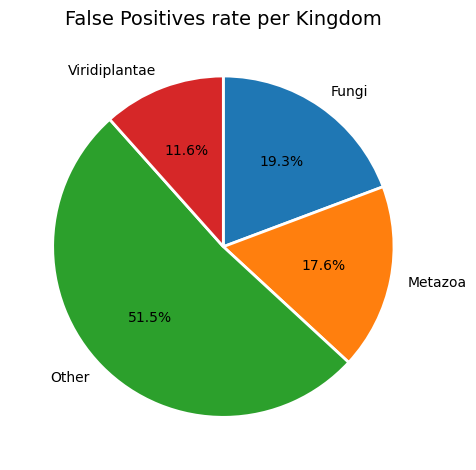

In [ ]:
#pie plot with false positive for kingdom classification
false_positives=prediction_dataset.query("Prediction=='FP'")
counts_falsepositive = (
    false_positives
    .groupby(["Kingdom", "Prediction"])
    .size()
    .rename("n")
    .reset_index()
)

counts_falsepositive["total"]=counts_falsepositive["Kingdom"].map(benchmark.query("Class=='Negative'").groupby(["Kingdom"]).size())
counts_falsepositive["percent"] = counts_falsepositive.groupby("Kingdom")["n"].transform(lambda s: ( s / counts_falsepositive["total"])*100)
fig, ax = plt.subplots()
ax.pie(
    counts_falsepositive["percent"],
    labels=counts_falsepositive["Kingdom"],
    autopct="%.1f%%",
    startangle=90,            
    counterclock=False,        
    wedgeprops={"linewidth": 2, "edgecolor": "white"}
)
ax.set_title("False Positives rate per Kingdom", fontsize=14)
ax.set_aspect("equal")         
plt.tight_layout()
plt.savefig("model_evaluation/FPR_Kingdom.png", dpi=300)
plt.show()

In [85]:
#fpr SVM

#compute the fpr on the entire dataset
fpr_svm=len(false_positives)/len(benchmark.query("Class=='Negative'"))
fpr_helix_svm=len(false_positive.query("HelixDomain==True"))/len(benchmark.query("Class=='Negative' and HelixDomain==True"))


In [86]:
print("FPR NEURAL NETWORK:",fpr_svm)
print("FPR NEURAL NETWORK only on transmembrane proteins:", fpr_helix_svm)

FPR NEURAL NETWORK: 0.009513150531617236
FPR NEURAL NETWORK only on transmembrane proteins: 0.05982905982905983


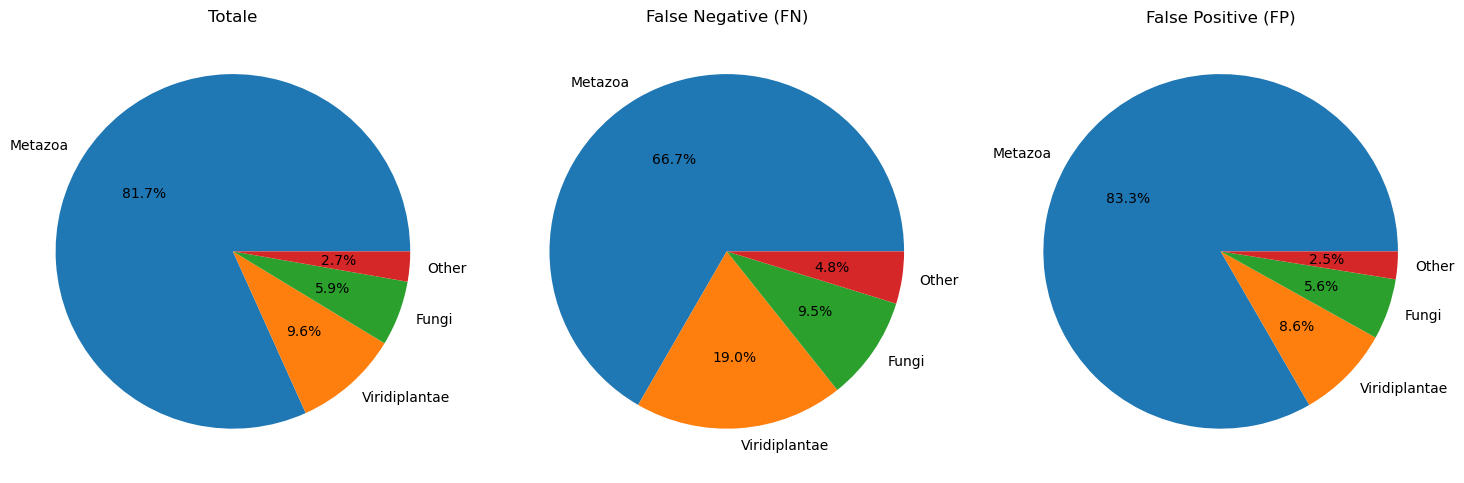

In [ ]:
# Taxonomic Composition of False Negatives, False Positives and Total Predictions
taxa_df=prediction_dataset.query("Class == 'Positive'").copy()

counts_total = taxa_df['Kingdom'].value_counts()
counts_fn = taxa_df[taxa_df['Prediction'] == 'FN']['Kingdom'].value_counts()
counts_fp = taxa_df[taxa_df['Prediction'] == 'TP']['Kingdom'].value_counts()


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].pie(counts_total, labels=counts_total.index, autopct='%1.1f%%')
axes[0].set_title('Totale')

axes[1].pie(counts_fn, labels=counts_fn.index, autopct='%1.1f%%')
axes[1].set_title('False Negative (FN)')

axes[2].pie(counts_fp, labels=counts_fp.index, autopct='%1.1f%%')
axes[2].set_title('False Positive (FP)')

plt.tight_layout()
plt.savefig("model_evaluation/Pieplot_species.png", dpi=300)
plt.show()


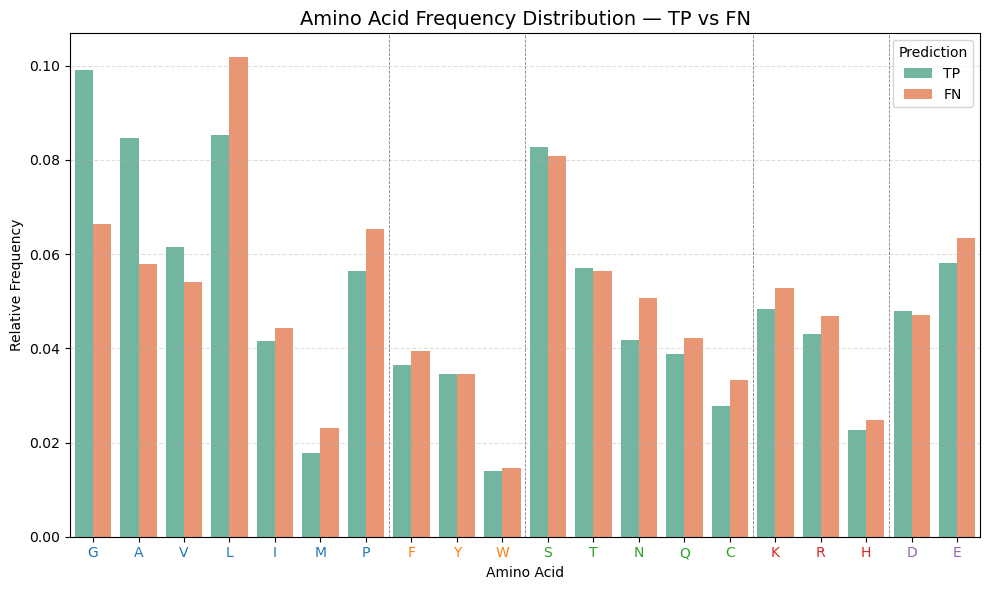

In [ ]:


# TP_freq e FN_freq have to be residue-indexed Series (es. index=['A','C',...])
TP_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "TP"][["Sequence"]].copy()
FN_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "FN"][["Sequence"]].copy()

def aa_frequency(df):
    all_seq = "".join(df["Sequence"])
    total = len(all_seq)
    freq = {aa: all_seq.count(aa) / total for aa in set(all_seq)}
    return pd.Series(freq).sort_index()
TP_freq = aa_frequency(TP_df_sequence)
FN_freq = aa_frequency(FN_df_sequence)
# Merge the two Pandas Series (TP_freq and FN_freq) for the plot

aa_compare = pd.DataFrame({
    "TP": TP_freq,
    "FN": FN_freq
}).fillna(0)

aa_compare = (
    aa_compare.reset_index()
              .melt(id_vars="index", var_name="Group", value_name="Frequency")
              .rename(columns={"index": "AminoAcid"})
)


aa_compare = pd.DataFrame({"TP": TP_freq, "FN": FN_freq}).fillna(0)

aa_compare = (
    aa_compare.reset_index()
              .melt(id_vars="index", var_name="Group", value_name="Frequency")
              .rename(columns={"index": "AminoAcid"})
)

aa_categories = {
    'nonpolar': list("GAVLIMP"),
    'aromatic': list("FYW"),
    'polar':    list("STNQC"),
    'positive': list("KRH"),
    'negative': list("DE"),
}

aa_order = [
    'G','A','V','L','I','M','P',
    'F','Y','W',
    'S','T','N','Q','C',
    'K','R','H',
    'D','E'
]

# mapping AA
res_to_cat = {aa: cat for cat, aas in aa_categories.items() for aa in aas}
aa_compare["AminoAcid"] = pd.Categorical(aa_compare["AminoAcid"], categories=aa_order, ordered=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=aa_compare,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    order=aa_order,
    palette="Set2"
)

ax.set_title("Amino Acid Frequency Distribution — TP vs FN", fontsize=14)
ax.set_xlabel("Amino Acid")
ax.set_ylabel("Relative Frequency")
ax.grid(axis='y', linestyle="--", alpha=0.4)
ax.legend(title="Prediction")

# label color based on category
cat_colors = {
    'nonpolar':'#1f77b4',
    'aromatic':'#ff7f0e',
    'polar':'#2ca02c',
    'positive':'#d62728',
    'negative':'#9467bd'
}
for label in ax.get_xticklabels():
    aa = label.get_text()
    cat = res_to_cat.get(aa)
    if cat:
        label.set_color(cat_colors[cat])

# separating lines between groups
group_boundaries = []
current_cat = None
for i, aa in enumerate(aa_order):
    cat = res_to_cat[aa]
    if current_cat is None:
        current_cat = cat
    elif cat != current_cat:
        group_boundaries.append(i - 0.5)
        current_cat = cat

for x in group_boundaries:
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.show()

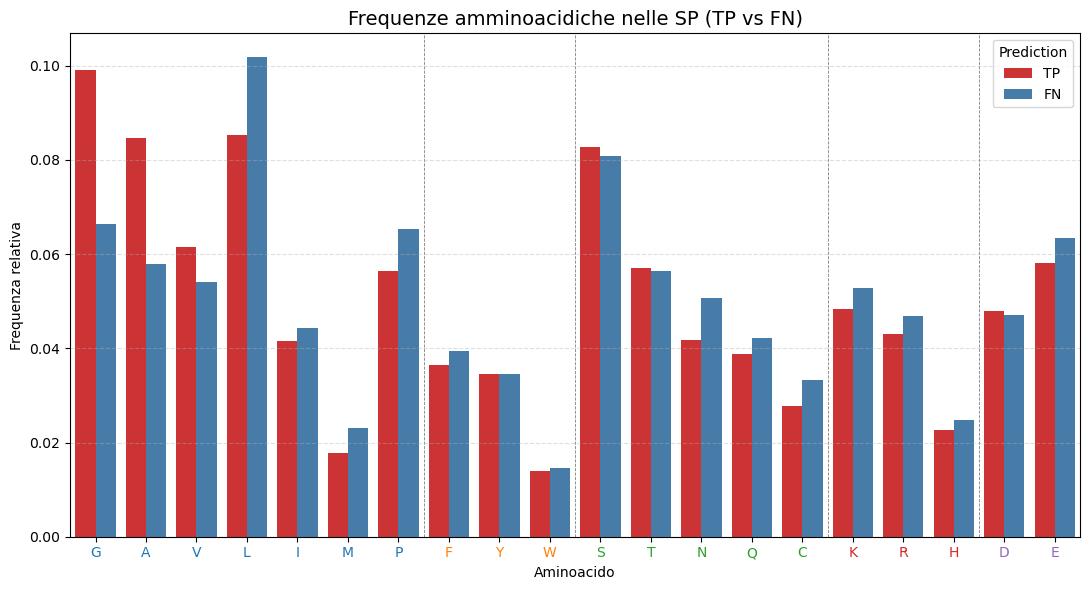

In [ ]:
SP_df = prediction_dataset[prediction_dataset["Prediction"].isin(["TP", "FN"])][["SPStart", "SPEnd", "Sequence", "Prediction"]].copy()

def SP_aa_frequency(df):
    for index, row in df.iterrows():
        seq = row["Sequence"]
        start = int(row["SPStart"]) - 1
        end = int(row["SPEnd"])
        df.loc[index, "SPSequence"] = seq[start:end]
    return df

SP_df = SP_aa_frequency(SP_df)

def SP_frequency(df, label):
    label_df = df[df["Prediction"] == label]
    all_seq = "".join(label_df["SPSequence"].dropna().astype(str))
    total = len(all_seq)
    if total == 0:
        return pd.Series(dtype=float)
    unique_aa = sorted(set(all_seq))
    freq = {aa: all_seq.count(aa) / total for aa in unique_aa}
    return pd.Series(freq)


TP_ser = SP_frequency(SP_df, "TP").rename("TP")
FN_ser = SP_frequency(SP_df, "FN").rename("FN")

freq_df = pd.concat([TP_ser, FN_ser], axis=1).fillna(0)


plt.figure(figsize=(11, 6))
ax = sns.barplot(
    data=aa_compare,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    order=aa_order,
    palette="Set1"
)
ax.set_title("AA Frequencies SP (TP vs FN)", fontsize=14)
ax.set_xlabel("Aminoacids")
ax.set_ylabel("Frequence")
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend(title="Prediction")

# separating lines between groups
cat_colors = {
    "nonpolar":"#1f77b4",
    "aromatic":"#ff7f0e",
    "polar":"#2ca02c",
    "positive":"#d62728",
    "negative":"#9467bd"
}
for tick in ax.get_xticklabels():
    aa = tick.get_text()
    cat = res_to_cat.get(aa)
    if cat:
        tick.set_color(cat_colors[cat])

# separating lines between categories
group_boundaries = []
current_cat = None
for i, aa in enumerate(aa_order):
    cat = res_to_cat[aa]
    if current_cat is None:
        current_cat = cat
    elif cat != current_cat:
        group_boundaries.append(i - 0.5)
        current_cat = cat

for x in group_boundaries:
    ax.axvline(x=x, color="gray", linestyle="--", linewidth=0.6, zorder=0)
    
plt.tight_layout()
plt.savefig("model_evaluation/AA_frequencies_SP.png", dpi=300)
plt.show()

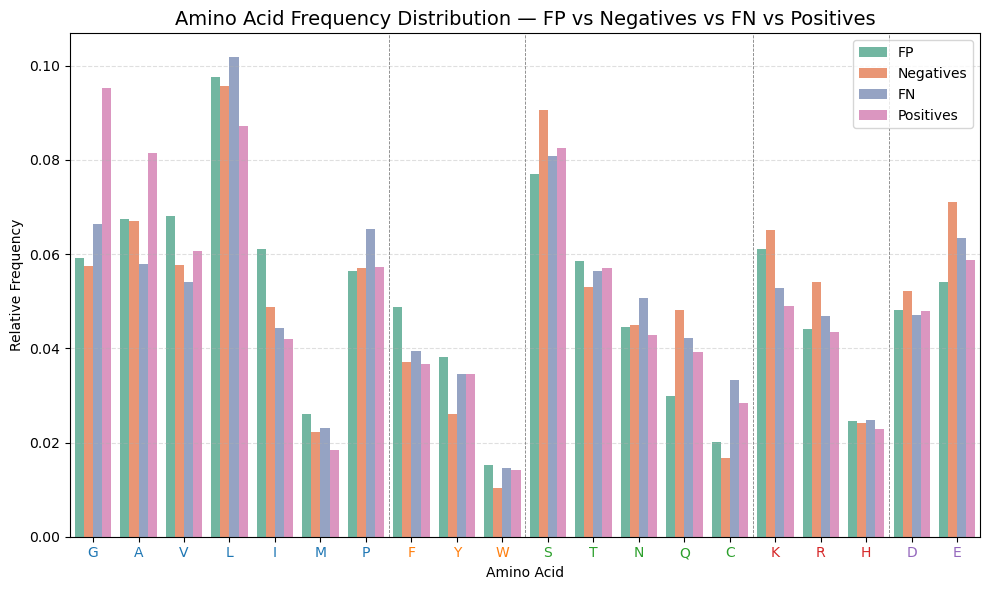

In [ ]:
#we now compare aa frequencies among all positives, all negatives, false positives and false negatives
FP_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "FP"][["Sequence"]].copy()
#FN_df_sequence = prediction_dataset[prediction_dataset["Prediction"] == "FN"][["Sequence"]].copy()
PP_df_sequence = prediction_dataset[prediction_dataset["Class"] == "Positive"][["Sequence"]].copy()
NN_df_sequence = prediction_dataset[prediction_dataset["Class"] == "Negative"][["Sequence"]].copy()

FP_freq = aa_frequency(FP_df_sequence)
#FN_freq = aa_frequency(FN_df_sequence)
PP_freq = aa_frequency(PP_df_sequence)
NN_freq = aa_frequency(NN_df_sequence)


# TP_freq e FN_freq have to be residue-indexed Series (es. index=['A','C',...])
aa_compare_tot = pd.DataFrame({"FP": FP_freq, "Negatives" : NN_freq , "FN": FN_freq , "Positives" : PP_freq}).fillna(0)

aa_compare_tot = (
    aa_compare_tot.reset_index()
              .melt(id_vars="index", var_name="Group", value_name="Frequency")
              .rename(columns={"index": "AminoAcid"})
)
aa_order = [
    'G','A','V','L','I','M','P',
    'F','Y','W',
    'S','T','N','Q','C',
    'K','R','H',
    'D','E'
]

# mapping AA
aa_categories = {
    'nonpolar': list("GAVLIMP"),
    'aromatic': list("FYW"),
    'polar':    list("STNQC"),
    'positive': list("KRH"),
    'negative': list("DE"),
}
cat_colors = {
    "nonpolar":"#1f77b4",
    "aromatic":"#ff7f0e",
    "polar":"#2ca02c",
    "positive":"#d62728",
    "negative":"#9467bd"
}



res_to_cat = {aa: cat for cat, aas in aa_categories.items() for aa in aas}
aa_compare_tot["AminoAcid"] = pd.Categorical(aa_compare_tot["AminoAcid"], categories=aa_order, ordered=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=aa_compare_tot,
    x="AminoAcid",
    y="Frequency",
    hue="Group",
    order=aa_order,
    palette="Set2"
)

ax.set_title("Amino Acid Frequency Distribution — FP vs Negatives vs FN vs Positives", fontsize=14)
ax.set_xlabel("Amino Acid")
ax.set_ylabel("Relative Frequency")
ax.grid(axis='y', linestyle="--", alpha=0.4)
ax.legend()

for label in ax.get_xticklabels():
    aa = label.get_text()
    cat = res_to_cat.get(aa)
    if cat:
        label.set_color(cat_colors[cat])

group_boundaries = []
current_cat = None
for i, aa in enumerate(aa_order):
    cat = res_to_cat[aa]
    if current_cat is None:
        current_cat = cat
    elif cat != current_cat:
        group_boundaries.append(i - 0.5)
        current_cat = cat

for x in group_boundaries:
    ax.axvline(x=x, color='gray', linestyle='--', linewidth=0.6)

plt.tight_layout()
plt.savefig("model_evaluation/AA_frequency_Distribution.png", dpi=300)
plt.show()

In [94]:
import logomaker as lm 

#Lets analyse FP , FN , TP , TN

#create sequence lists 
logo_pos_seqs=[]
logo_neg_seqs=[]
logo_fn_seqs=[]
logo_fp_seqs=[]


logo_neg = prediction_dataset.query("Class == 'Negative'")
#To make a logo, all sequences need to have the same length
for index,row in logo_neg.iterrows():
    sequence_to_recover=row["Sequence"]
    logo_neg_seqs.append(sequence_to_recover[1:18])
    if row["Prediction"]=="FP":
        logo_fp_seqs.append(sequence_to_recover[1:18])
    
logo_pos = prediction_dataset.query("Class == 'Positive'")
for index,row in logo_pos.iterrows():
    sequence_to_recover=row["Sequence"]
    cleavage_position=int(row["SPEnd"])
    logo_pos_seqs.append(sequence_to_recover[cleavage_position-13:cleavage_position+4])
    if row["Prediction"]=="FN":
        logo_fn_seqs.append(sequence_to_recover[cleavage_position-13:cleavage_position+4])

logo_fullseqs=[logo_pos_seqs ,logo_fn_seqs, logo_neg_seqs , logo_fp_seqs]



Sequence Logos computed using Information Content


C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.11872146 0.08675799 0.09589041 0.11415525 0.17808219 0.16438356
 0.08219178 0.15981735 0.15525114 0.10958904 0.25114155 0.06849315
 0.51141553 0.15068493 0.05022831 0.06392694 0.0913242 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.03196347 0.03652968 0.03652968 0.04109589 0.03652968 0.0456621
 0.05936073 0.02283105 0.03196347 0.03196347 0.06849315 0.02283105
 0.02739726 0.02283105 0.01369863 0.06849315 0.03196347]' has dtype incompatible with int64, please explicitly cast to a co

<Figure size 600x1400 with 0 Axes>

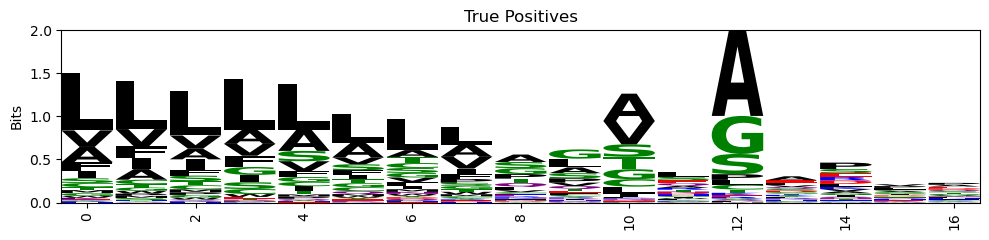

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.14285714 0.         0.28571429 0.14285714
 0.         0.42857143 0.42857143 0.28571429 0.14285714 0.14285714
 0.28571429 0.14285714 0.14285714 0.         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.         0.         0.         0.
 0.14285714 0.         0.14285714 0.         0.         0.
 0.         0.         0.         0.14285714 0.14285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

<Figure size 600x1400 with 0 Axes>

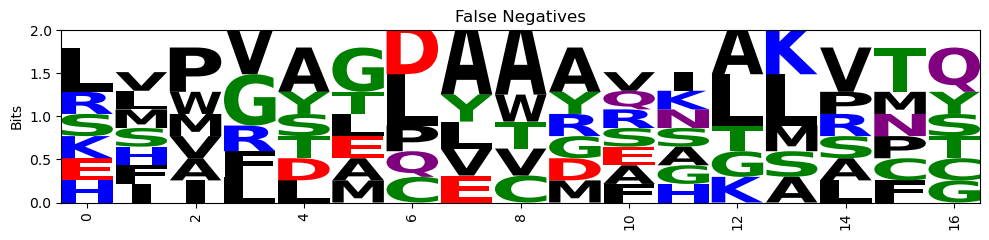

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21656407 0.10016788 0.08002238 0.08449916 0.07890319 0.07274762
 0.06771125 0.08226077 0.08170118 0.08170118 0.08058198 0.08282037
 0.06827084 0.07554561 0.08058198 0.08282037 0.07554561]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00503637 0.01063234 0.01231114 0.0184667  0.0201455  0.01790711
 0.01790711 0.01343033 0.01790711 0.0184667  0.0184667  0.01566872
 0.0184667  0.01510912 0.01678791 0.0201455  0.01063234]' has dtype incompatible with int64, please explicitly cast to a c

<Figure size 600x1400 with 0 Axes>

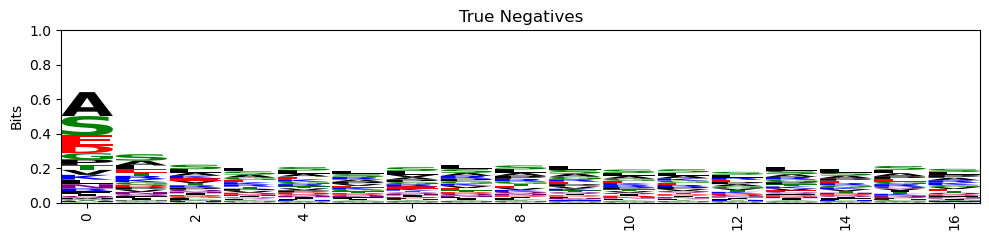

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.18644068 0.03389831 0.05084746 0.08474576 0.04237288 0.05084746
 0.09322034 0.11864407 0.09322034 0.11864407 0.08474576 0.08474576
 0.09322034 0.09322034 0.09322034 0.06779661 0.08474576]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01694915 0.03389831 0.02542373 0.02542373 0.04237288 0.02542373
 0.00847458 0.01694915 0.03389831 0.02542373 0.00847458 0.04237288
 0.01694915 0.03389831 0.03389831 0.02542373 0.00847458]' has dtype incompatible with int64, please explicitly cast to a c

<Figure size 600x1400 with 0 Axes>

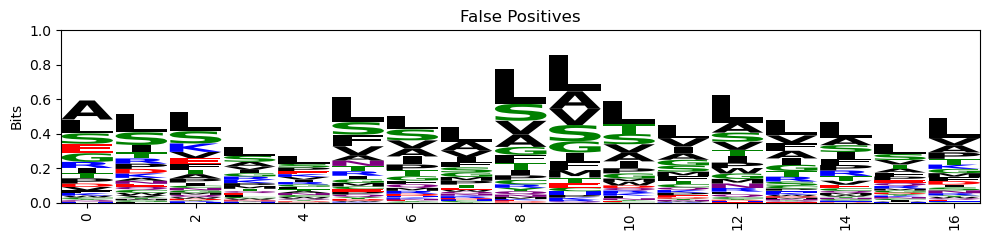

Sequence Logos computed using Probability of residues


C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.11872146 0.08675799 0.09589041 0.11415525 0.17808219 0.16438356
 0.08219178 0.15981735 0.15525114 0.10958904 0.25114155 0.06849315
 0.51141553 0.15068493 0.05022831 0.06392694 0.0913242 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.03196347 0.03652968 0.03652968 0.04109589 0.03652968 0.0456621
 0.05936073 0.02283105 0.03196347 0.03196347 0.06849315 0.02283105
 0.02739726 0.02283105 0.01369863 0.06849315 0.03196347]' has dtype incompatible with int64, please explicitly cast to a co

<Figure size 600x1400 with 0 Axes>

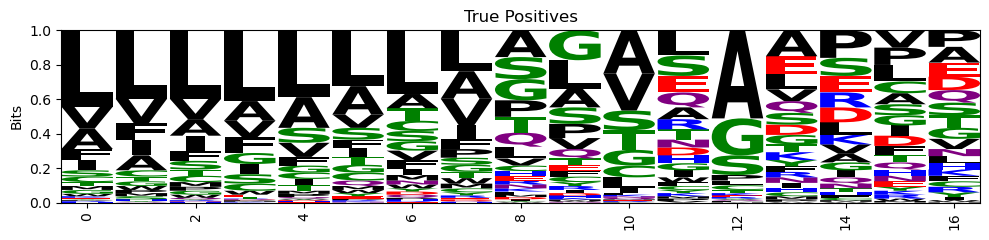

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.14285714 0.         0.28571429 0.14285714
 0.         0.42857143 0.42857143 0.28571429 0.14285714 0.14285714
 0.28571429 0.14285714 0.14285714 0.         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.         0.         0.         0.         0.         0.
 0.14285714 0.         0.14285714 0.         0.         0.
 0.         0.         0.         0.14285714 0.14285714]' has dtype incompatible with int64, please explicitly cast to a compatible dtype 

<Figure size 600x1400 with 0 Axes>

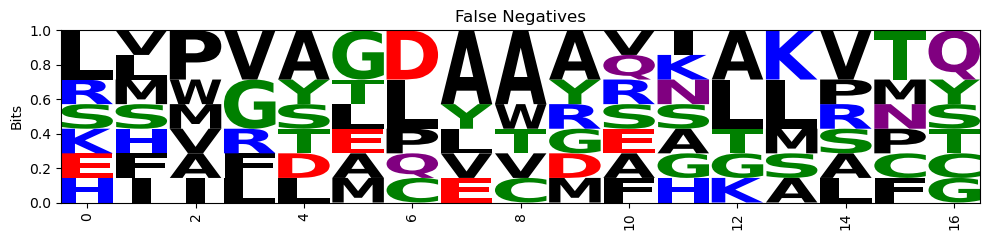

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.21656407 0.10016788 0.08002238 0.08449916 0.07890319 0.07274762
 0.06771125 0.08226077 0.08170118 0.08170118 0.08058198 0.08282037
 0.06827084 0.07554561 0.08058198 0.08282037 0.07554561]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.00503637 0.01063234 0.01231114 0.0184667  0.0201455  0.01790711
 0.01790711 0.01343033 0.01790711 0.0184667  0.0184667  0.01566872
 0.0184667  0.01510912 0.01678791 0.0201455  0.01063234]' has dtype incompatible with int64, please explicitly cast to a c

<Figure size 600x1400 with 0 Axes>

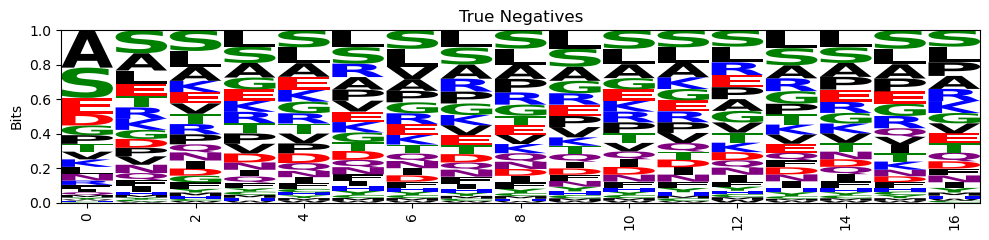

C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.18644068 0.03389831 0.05084746 0.08474576 0.04237288 0.05084746
 0.09322034 0.11864407 0.09322034 0.11864407 0.08474576 0.08474576
 0.09322034 0.09322034 0.09322034 0.06779661 0.08474576]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  prob_df.loc[:, :] = vals / vals.sum(axis=1)[:, np.newaxis]
C:\Users\chari\.conda\envs\lab_final\lib\site-packages\logomaker\src\matrix.py:270: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.01694915 0.03389831 0.02542373 0.02542373 0.04237288 0.02542373
 0.00847458 0.01694915 0.03389831 0.02542373 0.00847458 0.04237288
 0.01694915 0.03389831 0.03389831 0.02542373 0.00847458]' has dtype incompatible with int64, please explicitly cast to a c

<Figure size 600x1400 with 0 Axes>

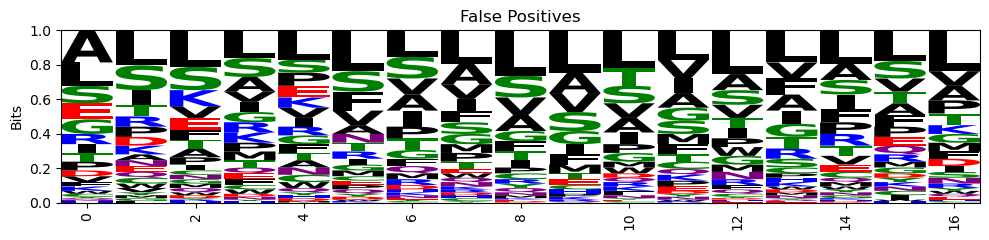

In [ ]:
# Sequence logo --> metric = information content
count=1
print("Sequence Logos computed using Information Content")
for i , j in zip(logo_fullseqs , ["True Positives" , "False Negatives", "True Negatives" , "False Positives" ]):
    #create an alignment matrix
    logo_mat=lm.alignment_to_matrix(sequences=i, to_type='information',characters_to_ignore='.-X', pseudocount=0 )
    #plot the sequence logo
    plt.figure(figsize=(6,14))
    lm.Logo(logo_mat, shade_below=.5, fade_below=.5, color_scheme="chemistry")
    plt.xticks(rotation=90)
    plt.ylabel("Bits")
    if j in ["True Negatives" , "False Positives" ]:
        plt.ylim(0, 1.0)  # Adjust the maximum Y-axis limit
    else:
        plt.ylim(0, 2.0)  # Adjust the maximum Y-axis limit
    plt.title(j)
    plt.tight_layout()
    plt.savefig(f"model_evaluation/figure12A-{count}.png", dpi=300)
    plt.show()
    count=count+1

# Sequence logo --> metric = probability
count=1
print("Sequence Logos computed using Probability of residues")
for i , j in zip(logo_fullseqs , ["True Positives" , "False Negatives", "True Negatives" , "False Positives" ]):
    #create an alignment matrix
    logo_mat=lm.alignment_to_matrix(sequences=i, to_type='probability',characters_to_ignore='.-X', pseudocount=0 )
    #plot the sequence logo
    plt.figure(figsize=(6,14))
    lm.Logo(logo_mat, shade_below=.5, fade_below=.5, color_scheme="chemistry")
    plt.xticks(rotation=90)
    plt.ylabel("Bits")
    plt.title(j)
    plt.tight_layout()
    plt.savefig(f"model_evaluation/Sequence_Logo-{count}.png", dpi=300) 
    plt.show()
    count=count+1

In [95]:
# Viridaeplante analysis
plant_df = prediction_dataset.query("Kingdom == 'Viridiplantae'")
print("False Positive rate in plant entries: "+str(plant_df.query("Prediction == 'FP'").shape[0] / plant_df.query("Class == 'Negative'").shape[0]))
print("False Positive rate in entire benchmark set:" , fpr_svm)
print("\nIn total we have "+str(plant_df.shape[0])+" entries")
print("Out of all entries in plant kingdom "+str(plant_df.query("OrganismName == 'Arabidopsis thaliana'").shape[0])+" of them are from Arabidopsis")

fpr_ara = plant_df.query("OrganismName == 'Arabidopsis thaliana' and Prediction == 'FP'").shape[0] / plant_df.query("OrganismName == 'Arabidopsis thaliana' and Class == 'Negative'").shape[0]
print("False Positive rate in Arabidopsis entries:" , fpr_ara)

fpr_not = plant_df.query("OrganismName != 'Arabidopsis thaliana' and Prediction == 'FP'").shape[0] / plant_df.query("OrganismName != 'Arabidopsis thaliana' and Class == 'Negative'").shape[0]
print("False Positive rate in all other entries:", fpr_not)

False Positive rate in plant entries: 0.00625
False Positive rate in entire benchmark set: 0.009513150531617236

In total we have 341 entries
Out of all entries in plant kingdom 265 of them are from Arabidopsis
False Positive rate in Arabidopsis entries: 0.0038461538461538464
False Positive rate in all other entries: 0.016666666666666666
